In [35]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter
from scipy.optimize import curve_fit
import math
import numba as nb
from testing_sample import *
import numpy as np


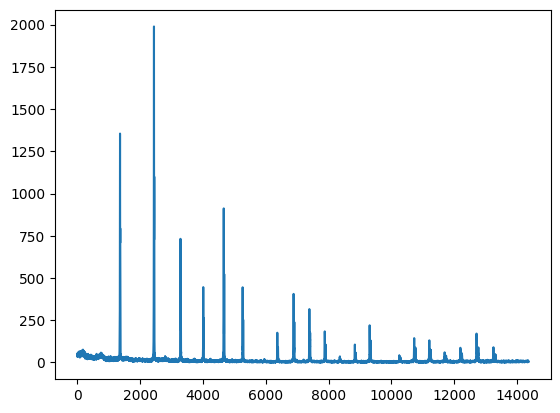

In [36]:
#create class element - aparature
ap = Data_file(-1)

plt.plot(ap.counts)

In [37]:
# for i in range(len(ap.counts)):
#     if ap.counts[i]>30:
#         corr_ap_index.append(i)
#         corr_ap_counts.append(ap.counts[i])

In [38]:
corr_ap_counts,x_corr_ap_counts = [],[]
for i in range(len(ap.counts)):
    if ap.counts[i]>20:
        corr_ap_counts.append(ap.counts[i])
        x_corr_ap_counts.append(ap.x[i])
        
nr_of_step = len(corr_ap_counts)
# x_counts_above_40 = np.linspace(ap.theta_start, ap.theta_stop, nr_of_step)
if nr_of_step > 1:
    step = (ap.theta_stop - ap.theta_start) / (nr_of_step - 1)
else:
    step = 0.0
print(step)

0.05141185412596401


In [39]:
def peak_detect_ap(counts, x, heigh, dist, prom,theta_start, step, eps = 4, plotting=False,fitting = False,fit_range = 10):
    ''' If fitting = False - function return values:
    len(peaks),len(correct_peaks)/len(two_theta),heigh,dist,prom ;
    If fitting = True - function return values:
    peaks,correct_peaks,index_corrected,gauss_fit,_  '''
    peaks, _ = find_peaks(counts)#, height=heigh, distance=dist, prominence=prom)
    if len(peaks) == 0:
        print(" Nie znaleziono pików - spróbuj obniżyć progu 'height' lub 'prominence'.")
        return False
    fitted_params,r2_list,gauss_fit  = [],[],[]  # (A, x0, sigma) dla każdego dopasowanego piku
    for pk in peaks:
        # ogranicz dane do małego okna wokół piku
        left = max(0, pk - fit_range)
        right = min(len(x), pk + fit_range)
        x_fit = x[left:right]
        y_fit = counts[left:right]
        A_guess = counts[pk]
        x0_guess = x[pk]
        sigma_guess = 1.0
        try:
            popt, _ = curve_fit(
                gaussian, x_fit, y_fit,
                p0=[A_guess, x0_guess, sigma_guess],
                bounds=([0.0, x0_guess - 5.0, 0.01],
                        [np.max(counts) * 5, x0_guess + 5.0, 10.0])
            )
            fitted_params.append(popt)
            A_fit, x0_fit, sigma_fit = popt
            # oblicz R² lokalnie
            gauss_fit.append([A_fit, x0_fit, sigma_fit])
            r2_list.append(rr2(
                np.asarray(x_fit, dtype=np.float64),
                np.asarray(y_fit, dtype=np.float64),
                np.float64(A_fit),
                np.float64(x0_fit),
                np.float64(sigma_fit)
            ))
        except RuntimeError:
            fitted_params.append((np.nan, np.nan, np.nan))
            r2_list.append(np.nan)
    # if plotting == True:
    #     plot_gauss(correct_peaks,peaks, counts, x, two_theta,30)
    return len(peaks),peaks,heigh,dist,prom,gauss_fit


In [40]:
len_peaks,peaks,heigh,dist,prom,gauss_fit = peak_detect_ap(corr_ap_counts,x_corr_ap_counts,0,0,0,ap.theta_start,step)

In [41]:
def plot_gauss_ap(peaks,count,x,segment_width = 15):
    x_min = np.min(x)
    x_max = np.max(x)
    # szerokość segmentu (np. 20° 2θ)
    num_segments = int(np.ceil((x_max - x_min) / segment_width))
    print(f"\nTworzę {num_segments} wykresów (co {segment_width}° 2θ)...")
    for seg in range(num_segments):
        seg_start = x_min + seg * segment_width
        seg_end = seg_start + segment_width
        mask = (x >= seg_start) & (x < seg_end)
        if not np.any(mask):
            continue
        x_seg = x[mask]
        y_seg = count[mask]
        plt.figure(figsize=(8, 5))
        plt.plot(x_seg, y_seg, label='Dane (po baseline)', alpha=0.6)
        plt.plot(ap.x, ap.counts, label='Dane (po baseline)', alpha=0.6, color = "pink")
        local_peaks = [pk for pk in peaks if seg_start <= x[pk] < seg_end]
        plt.scatter(x[local_peaks], count[local_peaks], color='k', zorder=10, label='Piki')
        plt.xlim(seg_start, seg_end)
        # plt.ylim(y_seg.min() * 0.9, y_seg.max() * 1.1)
        plt.ylim(0, y_seg.max() * 1.1)
        plt.title(f'Dopasowanie Gaussów: {seg_start:.1f}–{seg_end:.1f}° 2θ')
        plt.xlabel('2θ [°]')
        plt.ylabel('Intensywność')
        plt.legend(fontsize=8)
        plt.tight_layout()
        plt.show()


Tworzę 23 wykresów (co 5° 2θ)...


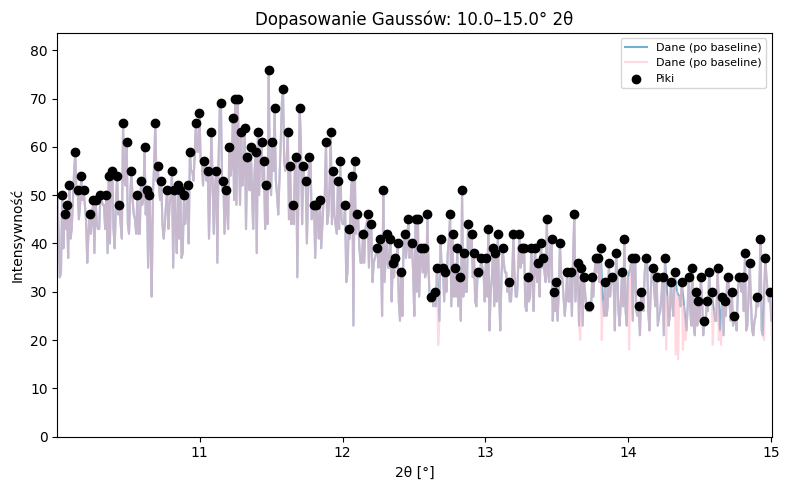

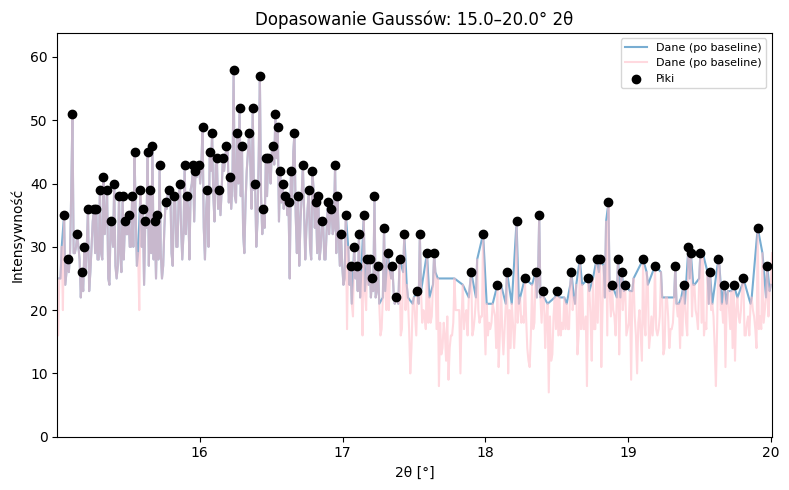

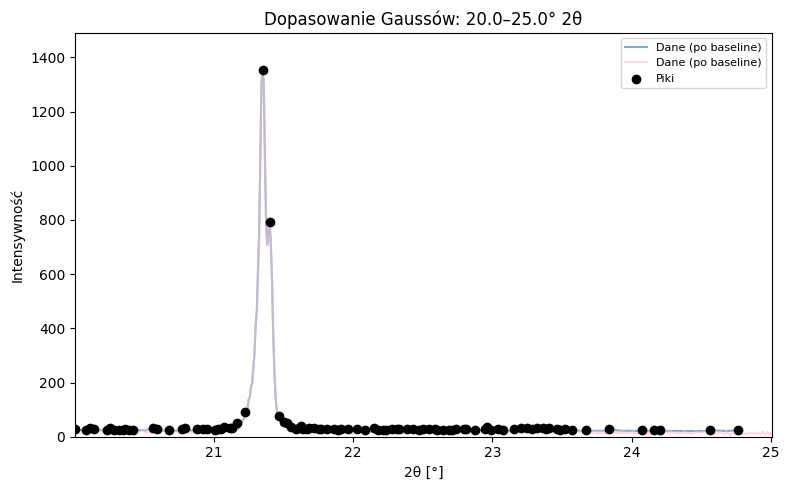

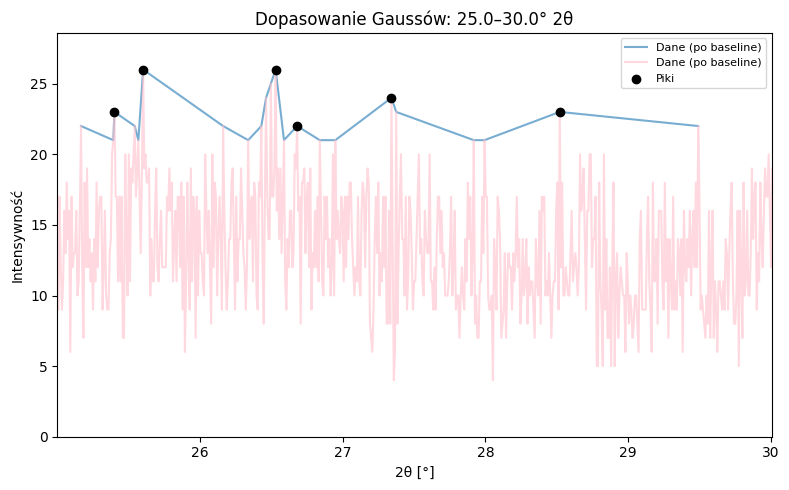

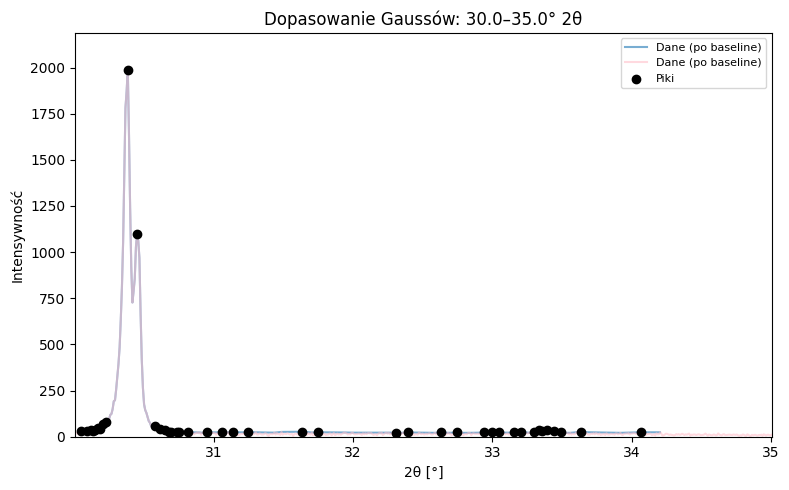

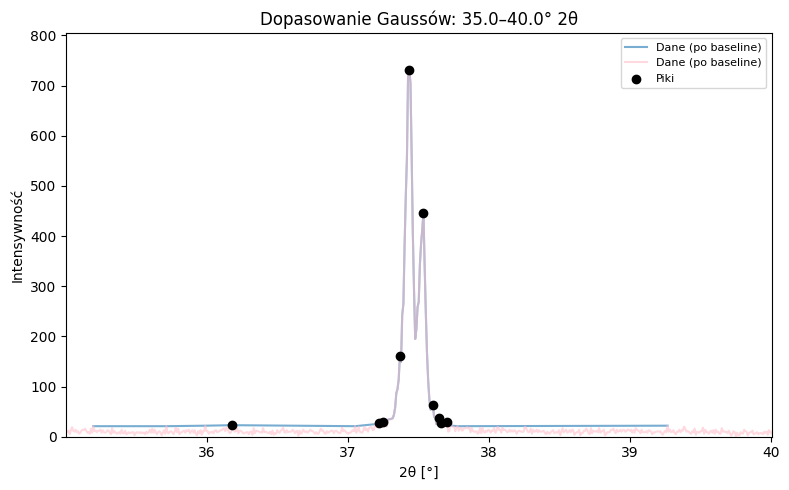

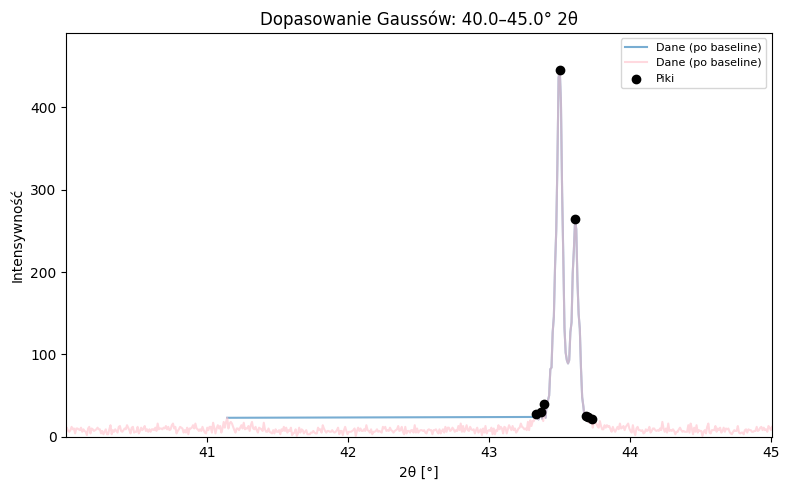

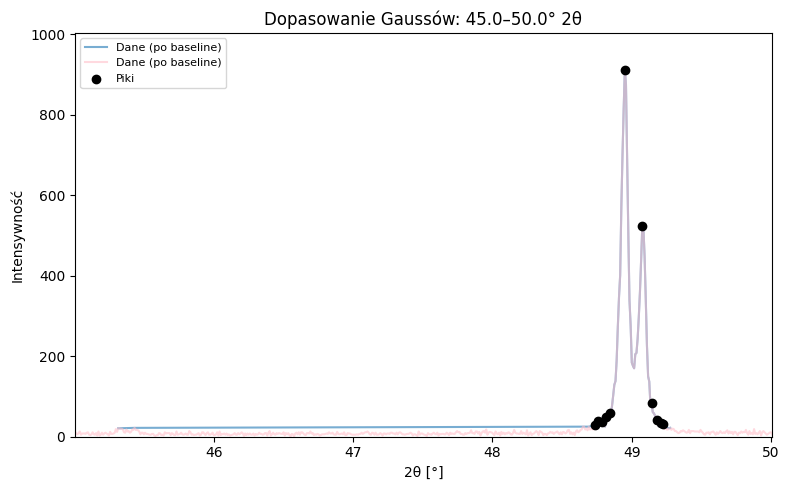

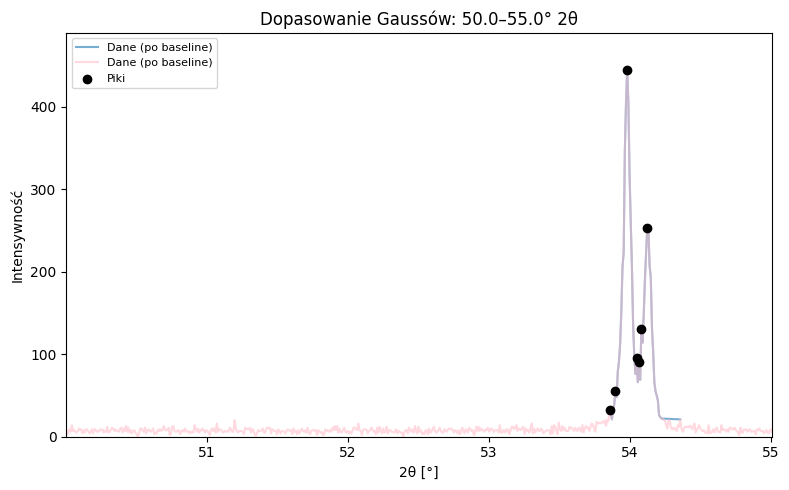

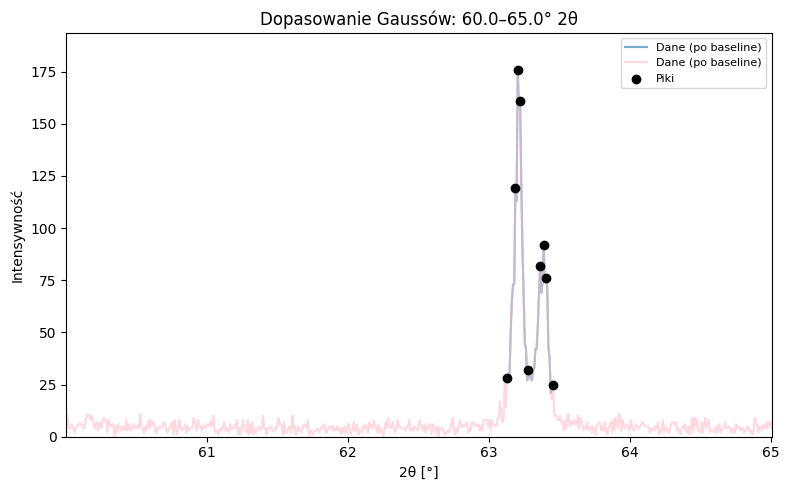

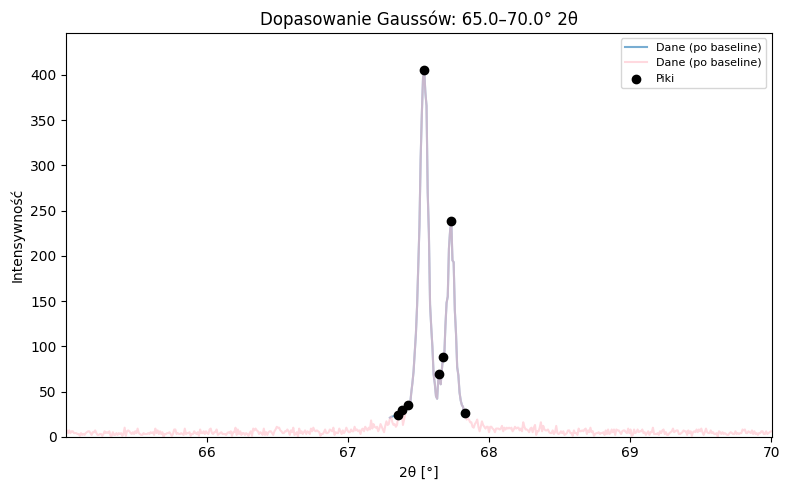

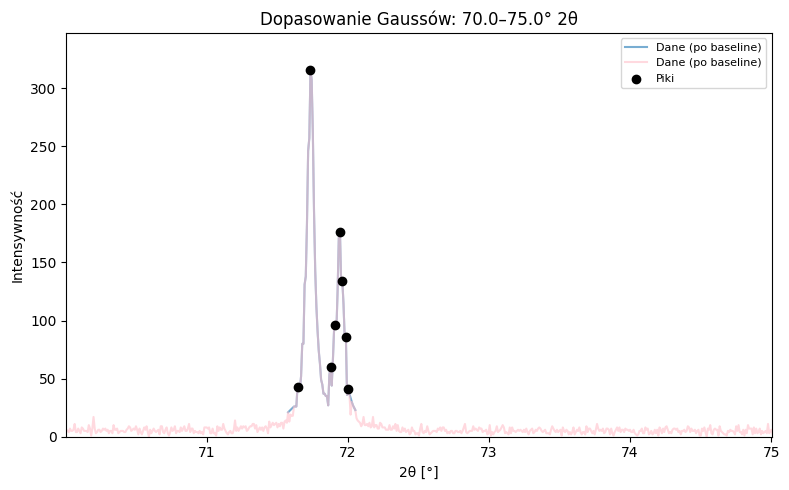

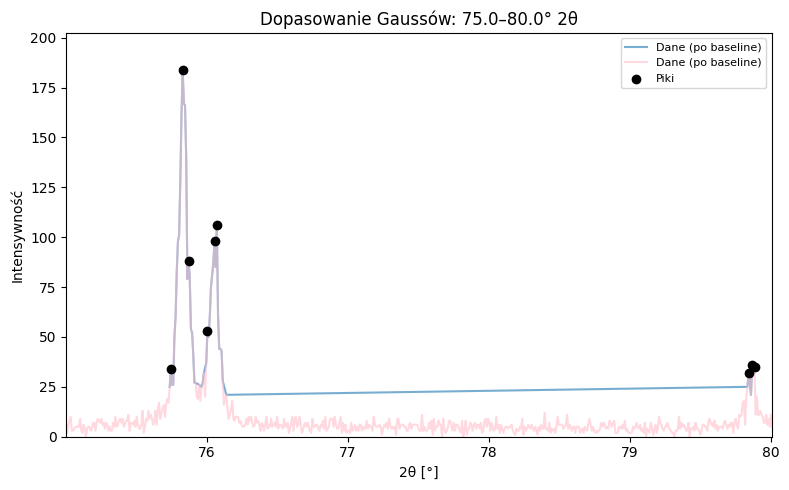

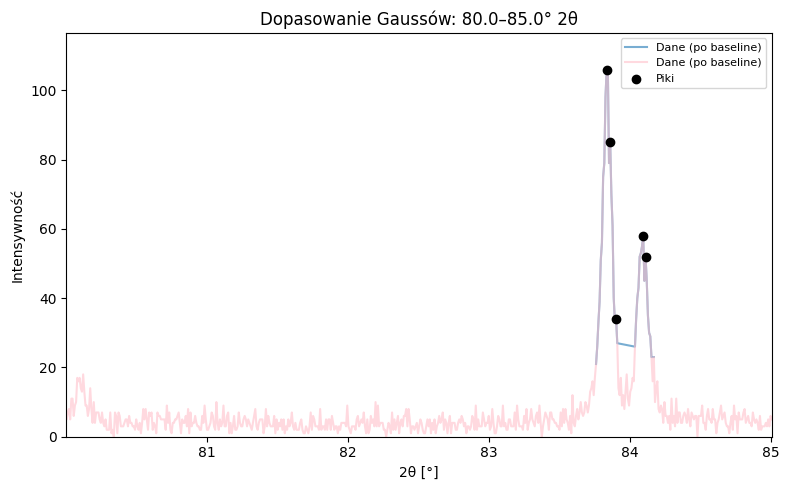

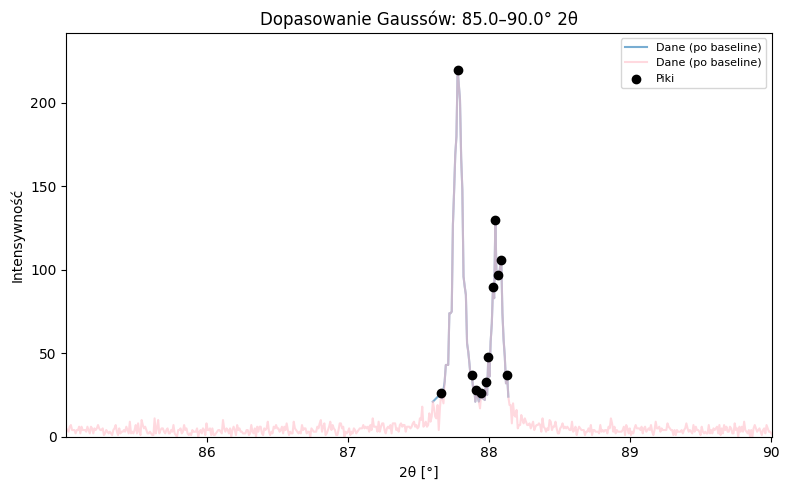

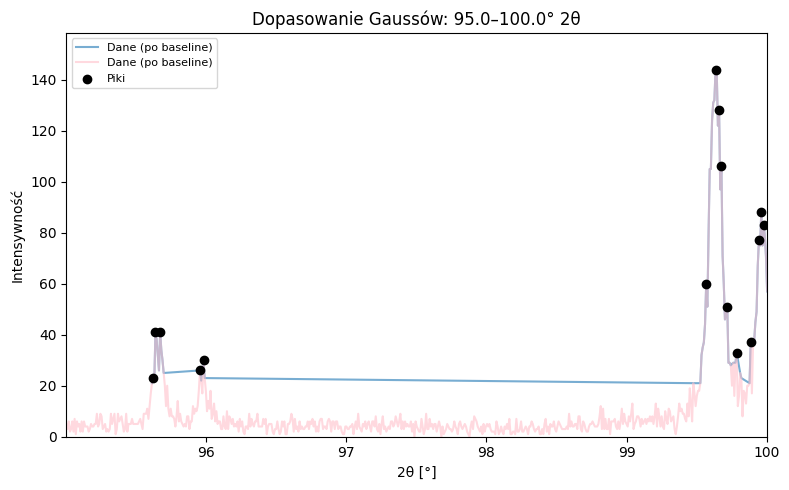

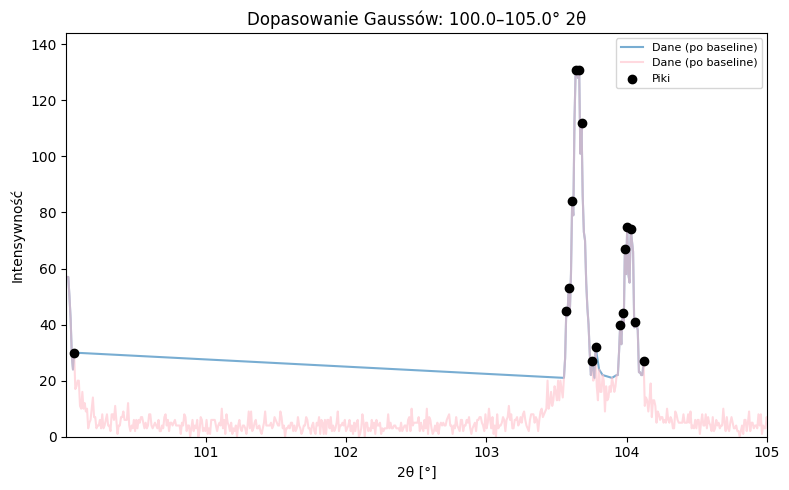

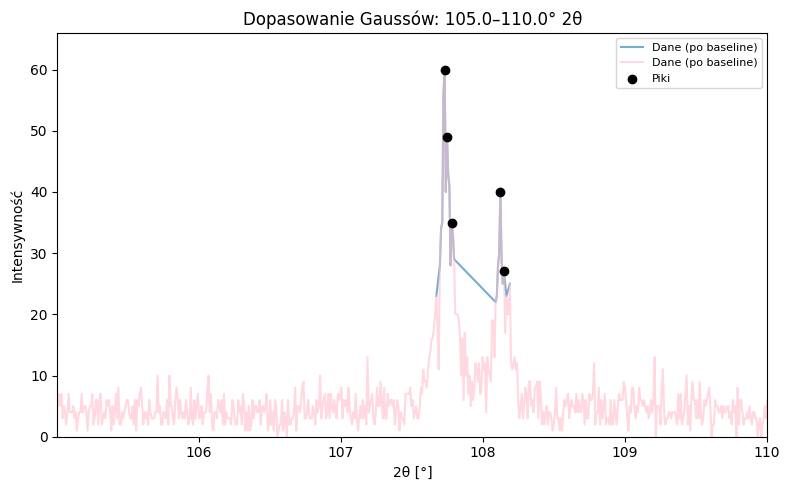

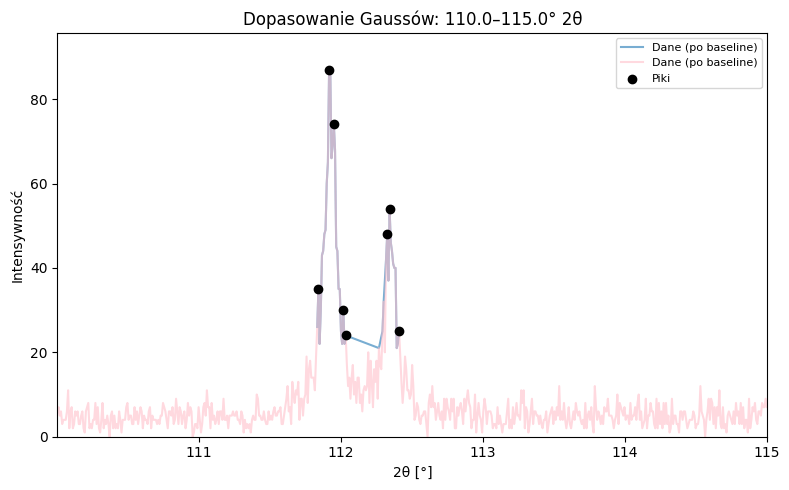

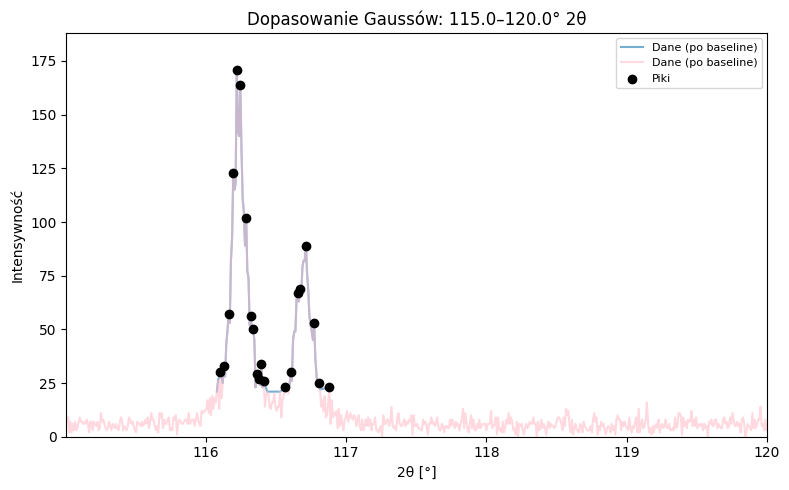

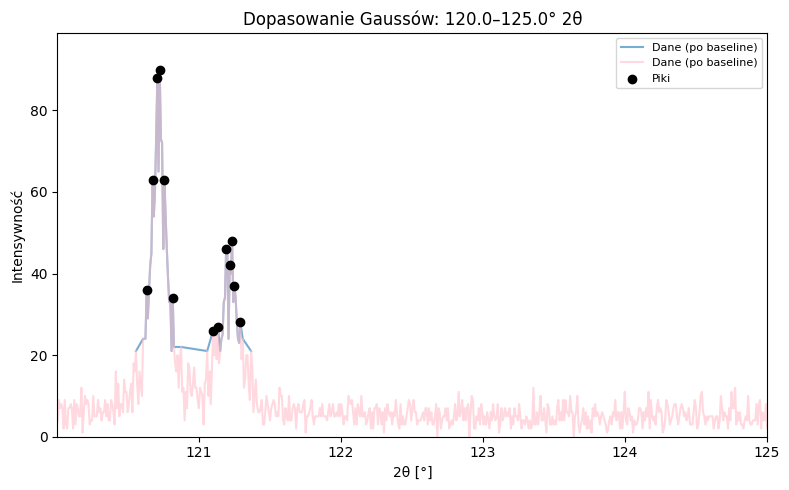

In [42]:
plot_gauss_ap(peaks,np.asarray(corr_ap_counts),np.asarray(x_corr_ap_counts),segment_width=5)

In [43]:
from scipy.signal import find_peaks, savgol_filter

def detect_xrd_peaks(counts, x,
                     smoothing_window = 21,
                     polyorder = 3,
                     min_prom = 20,
                     min_width = 3,
                     min_distance = None,
                     plotting=False):

    # 1. Wygładzanie widma
    smoothed = savgol_filter(counts, smoothing_window, polyorder)

    # 2. Ustawienie minimalnego dystansu między pikami
    if min_distance is None:
        min_distance = int(len(counts) * 0.002)  # ok. 0.2% zakresu

    # 3. Detekcja pików
    peaks, props = find_peaks(
        smoothed,
        prominence=min_prom,
        width=min_width,
        distance=min_distance
    )
    fit_range = 10
    fitted_params,r2_list,gauss_fit  = [],[],[]  # (A, x0, sigma) dla każdego dopasowanego piku
    for pk in peaks:
        # ogranicz dane do małego okna wokół piku
        left = max(0, pk - fit_range)
        right = min(len(x), pk + fit_range)
        x_fit = x[left:right]
        y_fit = counts[left:right]
        A_guess = counts[pk]
        x0_guess = x[pk]
        sigma_guess = 1.0
        try:
            popt, _ = curve_fit(
                gaussian, x_fit, y_fit,
                p0=[A_guess, x0_guess, sigma_guess],
                bounds=([0.0, x0_guess - 5.0, 0.01],
                        [np.max(counts) * 5, x0_guess + 5.0, 10.0])
            )
            fitted_params.append(popt)
            A_fit, x0_fit, sigma_fit = popt
            # oblicz R² lokalnie
            gauss_fit.append([A_fit, x0_fit, sigma_fit])
            r2_list.append(rr2(
                np.asarray(x_fit, dtype=np.float64),
                np.asarray(y_fit, dtype=np.float64),
                np.float64(A_fit),
                np.float64(x0_fit),
                np.float64(sigma_fit)
            ))
        except RuntimeError:
            fitted_params.append((np.nan, np.nan, np.nan))
            r2_list.append(np.nan)
    if plotting:
        plt.figure(figsize=(8,5))
        plt.plot(x, smoothed, label='Wygładzone dane')
        plt.scatter(x[peaks], smoothed[peaks], color='red', s=30, label='Piki')
        plt.plot(x, counts, alpha=0.3, color='gray', label='Surowe dane')
        plt.legend()
        plt.show()

    return peaks, smoothed,gauss_fit


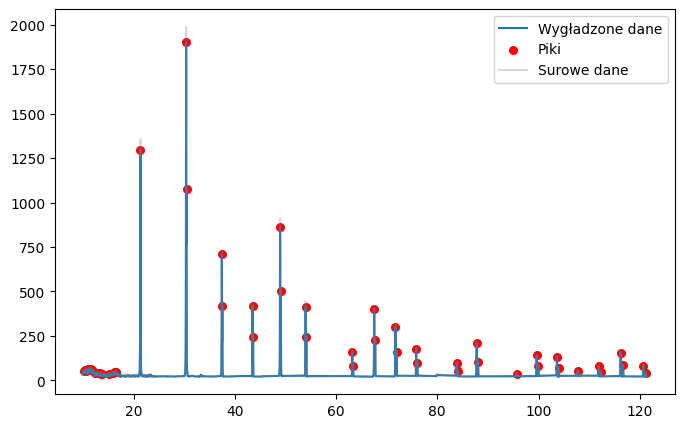

In [44]:
peaks, smoothed ,gauss_fit= detect_xrd_peaks(
    np.asarray(corr_ap_counts),
    np.asarray(x_corr_ap_counts),
    smoothing_window=8,   # szersze wygładzenie
    min_prom=10,           # wymagaj 30 jednostek amplitudy nad szumem
    min_width=2,           # minimalna szerokość piku
    plotting=True
)


In [45]:
print(len(peaks))
print(len(smoothed))

57
2335


In [46]:
# plot_gauss_ap(peaks,np.asarray(corr_ap_counts),np.asarray(x_corr_ap_counts),segment_width=5)

In [57]:
print(gauss_fit)
print(len(gauss_fit))

[[np.float64(50.25095349594915), np.float64(10.17645464992292), np.float64(0.24392846463642914)], [np.float64(50.7783852900968), np.float64(10.47467326677656), np.float64(0.18077367418084045)], [np.float64(115.67018895388684), np.float64(5.605783634054473), np.float64(3.7244928790259966)], [np.float64(49.862624407349394), np.float64(10.681625615598707), np.float64(0.22131252114275132)], [np.float64(59.88635394684728), np.float64(10.993209419492535), np.float64(0.11940871890524178)], [np.float64(53.28461168657509), np.float64(11.142604022246575), np.float64(0.23848847183673805)], [np.float64(59.167693183319514), np.float64(11.258646829664313), np.float64(0.12464804981226259)], [np.float64(91.6993584130983), np.float64(16.424632536845575), np.float64(4.84144934402037)], [np.float64(59.49415825849499), np.float64(11.562801008717694), np.float64(0.13456007200744372)], [np.float64(52.871198577577566), np.float64(11.720036697294358), np.float64(0.19219709696467505)], [np.float64(50.775724211

In [64]:
def finding_fwhm(peaks,gauss_fit):
    '''in order - A, mu,sigma '''
    N = len(peaks)
    fwhm = np.zeros(N)
    t_fwhm = np.zeros(N)
    for j in range(len(peaks)):
        fwhm[j] = 2 * gauss_fit[j][2]* math.sqrt(2 * math.log(2))
        t_fwhm[j] = gauss_fit[j][1]
    return fwhm,t_fwhm

In [65]:
fwhm,t_fwhm = finding_fwhm(peaks,gauss_fit)

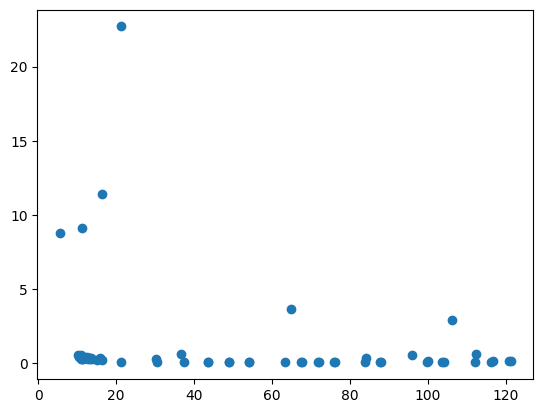

In [68]:
plt.scatter(t_fwhm,fwhm)

In [ ]:
# def finding_fwhm_plot(counts,x,gauss_fit,theta_start,step,plotting = True):
#     '''in order - A, mu,sigma '''
#     N = len(index_corrected)
#     fwhm = np.zeros(N)
#     t_fwhm = np.zeros(N)
#     diff = np.zeros(N)
#     for j in range(len(index_corrected)):
#         if plotting == True:
#             plt.scatter(x, counts, s=10, label="dane")
#             plt.plot(x, gaussian(x, *gauss_fit[index_corrected[j]]), label="dopasowany Gauss", linewidth=2,color = 'red')
#             plt.axvline(gauss_fit[index_corrected[j]][1])
#             plt.legend()
#             plt.xlim(gauss_fit[index_corrected[j]][1]-gauss_fit[index_corrected[j]][2]-1,gauss_fit[index_corrected[j]][1]+gauss_fit[index_corrected[j]][2]+1)
#             plt.ylim(0,gauss_fit[index_corrected[j]][0]+100)
#             plt.axhline(gauss_fit[index_corrected[j]][0]/2, color='r', linestyle='--', label='Pozioma linia')
#         max_index = int((gauss_fit[index_corrected[j]][1]-theta_start)/step )
#         if max_index>len(counts):
#             max_index = len(counts)
            
#         if max_index - 20 <= 0:
#             min = abs(counts[0]-(gauss_fit[index_corrected[j]][0]/2))
#             l_ind = 0
#             left_max_ind = 0
#         else:
#             min = abs(counts[max_index - 20]-(gauss_fit[index_corrected[j]][0]/2))
#             l_ind = max_index - 20
#             left_max_ind = max_index - 20
#         if max_index == len(counts):
#             min2 = abs(counts[-1]-(gauss_fit[index_corrected[j]][0]/2))
#             r_ind = max_index
#         else:
#             min2 = abs(counts[max_index]-(gauss_fit[index_corrected[j]][0]/2))
#             r_ind = max_index
    
#         for i in range(left_max_ind,max_index):
#             if abs(counts[i]-(gauss_fit[index_corrected[j]][0]/2))<min:
#                 min=abs(counts[i]-(gauss_fit[index_corrected[j]][0]/2))
#                 l_ind = i
#         if max_index+20>=len(counts):
#             right_max_ind = len(counts)
#         else:
#             right_max_ind = max_index+20
#         for i in range(max_index,right_max_ind):
#             if abs(counts[i]-(gauss_fit[index_corrected[j]][0]/2))<min2:
#                 min2=abs(counts[i]-(gauss_fit[index_corrected[j]][0]/2))
#                 r_ind = i
#         if plotting == True:
#             dd = [x[l_ind],x[r_ind]]
#             kk = [counts[l_ind],counts[r_ind]]
#             plt.scatter(dd,kk,color ='green')
#             plt.show()
#         diff[j] = (r_ind - l_ind) * step
#         fwhm[j] = 2 * gauss_fit[index_corrected[j]][2] * math.sqrt(2 * math.log(2))
#         t_fwhm[j] = gauss_fit[index_corrected[j]][1]
#     return fwhm,t_fwhm,diff